---
# Classificação de Demandas do Fala.BR - Oversampled
---
**Projeto do Bootcamp Machine Learning (Anderson Monteiro e Léo Maranhão de Mello)**

## Introdução



### **Descrição do projeto de machine learning**


**1- Descrição do problema ou tarefa:**
O problema consiste em classificar as demandas recebidas pela Ouvidoria da SUSEP, por meio do sistema Fala.BR.

**2- Descrição da solução de IA:**
Utilizaremos um processamento de NLP e testaremos modelos de regressão logística e Random Forest para classificação. A solução incluirá uma pipeline que realiza pré-processamento, treinamento e avaliação do modelo.

**3- Fonte de dados:**
A Ouvidoria forneceu um dataset com 1531 textos das demandas e suas classificações, no formato de planilha ODS. A classificação dos textos foi realizada pela própria Ouvidoria.

**4- Variáveis independentes (preditoras ou "features"):**
A variável independente é o texto recebido do Fala.BR.

**5- Variável dependente (resposta ou "target"):**
A variável dependente é a classificação do texto em uma das 17 classificações utilizadas pela Ouvidoria:

- Cadastro
- Capitalização
- Consulta Técnica
- DPVAT/SPVAT
- Não identificada
- Previdência Complementar Aberta
- Seguro Compreensivo
- Seguro de Automoveis
- Seguro de Crédito Interno
- Seguro de Danos
- Seguro de Pessoas
- Seguro de Responsabilidade
- Seguro de Transportes
- Seguro Fiança Locatícia
- Seguro Garantia
- Seguro Garantia Estendida
- Seguro Rural

In [1]:
# importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

!python -m spacy download pt_core_news_sm
import spacy

# Obtem os sinais de pontuação da língua portuguesa
import string

# instala módulo para ler ods
%pip install odfpy

%pip install optuna
import optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 46.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160672 sha256=fc729f3e6f4e311ceb04522b5727c858c0d64dd982451493b0eb6a548b3d343c
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━

## 1- Carregar dados

In [2]:
# monta o goole drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Carregar dados da planilha
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/Projeto IA - Amostra Anonimizada - Demandas úteis da ouvidoria 2023.ods", engine="odf")

## 2- Análise exploratória dos dados

In [4]:
# Análise exploratória dos dados
df.head()

,Demanda,Tipo de Resposta,Categoria,Motivo
0,Preciso retirar minha responsabilidade técnica...,Corretores - cadastro,Cadastro,Documentação
1,Prezados.Venho através dessa denunciar a práti...,Mercado não supervisionado,Seguro de Automoveis,Denúncia sobre mercado não supervisionado
2,Quero saber sobre seguro de vida e apolices fe...,Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços
3,"MUITO BOM DIA, estou recorrendo a este caminho...",Corretores - cadastro,Cadastro,Documentação
4,"Preciso, de uma verificação desta apólice! Apó...",Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços


In [5]:
# Descreva a estatística básica da variáveis
df.describe()


,Demanda,Tipo de Resposta,Categoria,Motivo
count,1530,1530,1530,1530
unique,1522,15,17,46
top,Bom dia me chamo T gostaria de uma ajuda para ...,Reclamação - Consumidor.gov.br,Cadastro,Documentação
freq,2,460,470,450


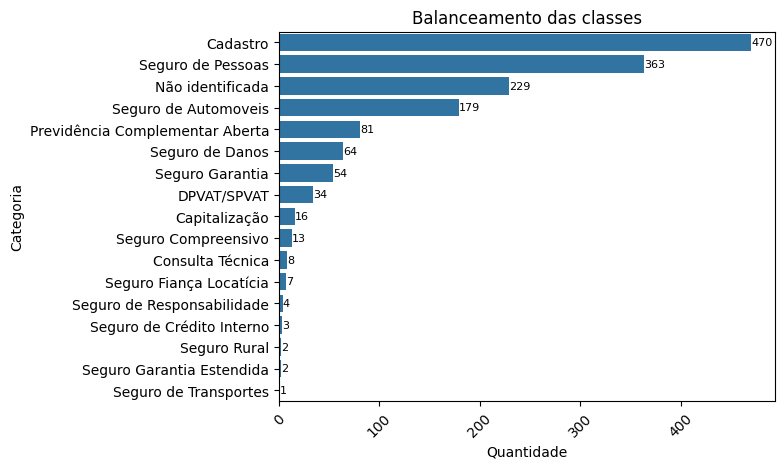

In [6]:
# Mostrar gráfico com o balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()


In [7]:
# Seguro de transporte possui apenas uma ocorrência.
# Por outro lado, capitalização, seguro compreensivo, consulta técnica, seguro fiança locatícia e os seguros de Responsabilidade, Crédito Interno,
# Rural, Garantia Estendida também possuem poucos menos de 5 casos. Iremos criar uma nova categoria, Outros,
# juntando esses seguros de baixa ocorrência.

# Renomear as categorias
df['Categoria'] = df['Categoria'].replace(['Capitalização', 'Seguro Compreensivo', 'Consulta Técnica', 'Seguro Fiança Locatícia', 'Seguro de Transportes', 'Seguro de Responsabilidade', 'Seguro de Crédito Interno', 'Seguro Rural', 'Seguro Garantia Estendida'], 'Outros')


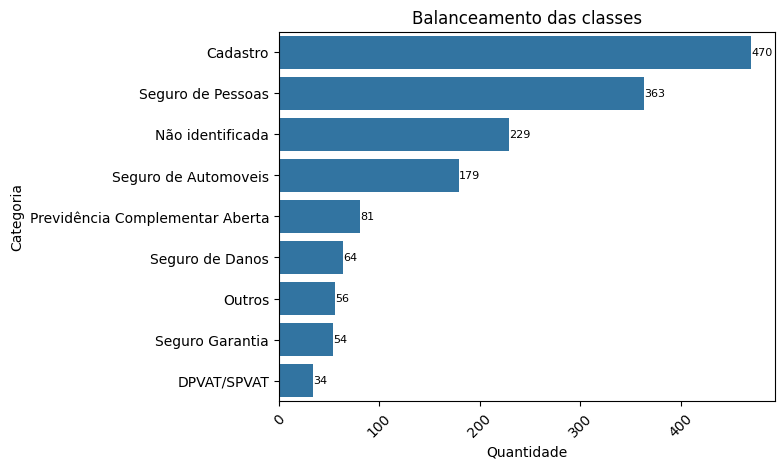

In [8]:
# Mostrar gráfico com o novo balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()

In [9]:
# Bag of Words no sklearn: usamos CountVectorizer
# instancia o transform CountVectorizer
vectorizer = CountVectorizer()

# tokeniza e cria o vocabulário
vectorizer.fit(df['Demanda'])

# mostra o vocabulário criado
print('Vocabulário: ')
print(vectorizer.vocabulary_)

# converte em números
print('\ndimensões da matrix: ')
vector = vectorizer.transform(df['Demanda'])

# mostra as dimensões da matrix de frequência
print(vector.shape)

# mostra os documentos codificados
feature_names = vectorizer.get_feature_names_out()
df_bag = pd.DataFrame(vector.toarray(), columns = feature_names)

# Apresenta os totais das colunas, ordenando em ordem decrescente
df_bag.sum().sort_values(ascending=False)

Vocabulário: 
{'preciso': 8843, 'retirar': 10099, 'minha': 7410, 'responsabilidade': 10025, 'técnica': 11460, 'da': 3307, 'empresa': 4376, 'credenciada': 3156, 'na': 7630, 'susep': 10949, 'não': 7868, 'estou': 4844, 'conseguindo': 2790, 'prezados': 8985, 'venho': 11681, 'através': 1438, 'dessa': 3753, 'denunciar': 3531, 'prática': 9232, 'de': 3363, 'venda': 11659, 'ilegal': 5982, 'seguro': 10443, 'temos': 11101, 'em': 4293, 'americana': 889, 'um': 11489, 'grupo': 5785, 'chamado': 2213, 'motor': 7526, 'home': 5868, 'https': 5908, 'grupomotorhome': 5786, 'com': 2449, 'br': 1833, 'comercializando': 2471, 'proteção': 9182, 'veicular': 11629, 'como': 2496, 'se': 10367, 'fosse': 5472, 'unidade': 11503, 'fica': 5288, 'localizada': 7005, 'rua': 10250, 'são': 10993, 'gabriel': 5603, '333': 1, 'bairro': 1660, 'manoel': 7165, 'diante': 3881, 'do': 4090, 'fato': 5197, 'narrado': 7644, 'solicito': 10744, 'fiscalização': 5376, 'aplicação': 1064, 'das': 3347, 'leis': 6842, 'cabíveis': 1904, 'para': 8

,0
de,7249
que,4596
33,4363
do,2747
não,2591
...,...
federa,1
fechasse,1
fecharam,1
fechamos,1


## 3- Preparação dos dados

In [10]:
# Substituição das categorias de y-train e y_test por dados numéricos
y_mapping = {
    'Cadastro': 0,
    'Seguro de Pessoas': 1,
    'Não identificada': 2,
    'Seguro de Automoveis': 3,
    'Previdência Complementar Aberta': 4,
    'Seguro de Danos': 5,
    'Outros': 6,
    'Seguro Garantia': 7,
    'DPVAT/SPVAT': 8
}

# Defina X e y
X = df['Demanda']
y = df['Categoria'].apply(lambda x: y_mapping[x])

# Dividir os dados em conjuntos de treino e teste
X_train_antes, X_test, y_train_antes, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_antes = pd.DataFrame(X_train_antes, columns=['Demanda'])

#Oversampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train_antes, y_train_antes)

y_train.value_counts()


,count
Categoria,
1,376
8,376
0,376
3,376
2,376
5,376
4,376
6,376
7,376


In [11]:
# Obtem as stopwords da língua portuguesa
stop_words = set(stopwords.words('portuguese'))


In [12]:
# Transforma X_train e X_test em minúsculas
X_train = X_train['Demanda'].str.lower()
X_test = X_test.str.lower()

# Retira as stop_words do X_train e X_test
X_train = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_test = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Substituir os sinais de pontuação e números de X_train e X_test por espaço em branco
X_train = X_train.apply(lambda x: re.sub(u'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', ' ', x))
X_test = X_test.apply(lambda x: re.sub(u'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', ' ', x))

# Substituir os sinais de pontuação e números de X_train e X_test por espaço em branco
X_train = X_train.apply(lambda x: re.sub(' {2,}', ' ', x))
X_test = X_test.apply(lambda x: re.sub(' {2,}', ' ', x))

# Lemmatization de X_train e X_test
nlp = spacy.load("pt_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

X_train = X_train.apply(lemmatize_text)
X_test = X_test.apply(lemmatize_text)

tfidf = TfidfVectorizer(min_df=4, max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


## 4- Vizualização dos tokens após Preparação

In [13]:
# Bag of Words no sklearn: usamos CountVectorizer
# instancia o transform CountVectorizer
vectorizer = CountVectorizer()

# tokeniza e cria o vocabulário
vectorizer.fit(X_train)

# mostra o vocabulário criado
print('Vocabulário: ')
print(vectorizer.vocabulary_)

# converte em números
print('\ndimensões da matrix: ')
vector = vectorizer.transform(X_train)

# mostra as dimensões da matrix de frequência
print(vector.shape)

# mostra os documentos codificados
feature_names = vectorizer.get_feature_names_out()
df_bag_pos = pd.DataFrame(vector.toarray(), columns = feature_names)

# Apresenta os totais das colunas, ordenando em ordem decrescente
df_bag_pos.sum().sort_values(ascending=False)

Vocabulário: 
{'bom': 982, 'tarde': 7255, 'gostar': 3560, 'saber': 6680, 'possível': 5673, 'consultar': 1714, 'beneficiár': 937, 'seguro': 6806, 'vida': 7725, 'irmã': 4137, 'mãe': 4901, 'falecer': 3181, 'recentemente': 6196, 'informação': 3944, 'caso': 1199, 'informar': 3934, 'favor': 3220, 'meio': 4680, 'consulta': 1711, 'obrigar': 5087, 'quantidade': 6062, 'valor': 7613, 'pagos': 5285, 'indenização': 3874, 'dpvat': 2522, 'ano': 428, 'cada': 1058, 'modalidade': 4799, 'despesa': 2271, 'assistência': 643, 'médico': 4905, 'suplementar': 7154, 'dams': 2011, 'invalidez': 4097, 'permanente': 5475, 'morte': 4836, 'solicitar': 7016, 'total': 7400, 'desembolsar': 2219, 'pagamento': 5277, 'olá': 5158, 'existir': 3100, 'algum': 301, 'nome': 5002, 'cunhar': 1972, 'eduardo': 2582, 'cpf': 1906, 'último': 7925, 'sábado': 7214, 'estar': 2967, 'auxiliar': 822, 'pai': 5290, 'organizar': 5206, 'assunto': 653, 'referente': 6273, 'filho': 3292, 'gentileza': 3504, 'qual': 6056, 'instituição': 4019, 'possar

,0
seguro,4863
dia,3032
seguradora,2303
fazer,2097
pedir,2078
...,...
cego,1
cedula,1
oq,1
or,1


## 5- Treinar o modelo

### SGDCClassifier

In [14]:
# Define o pipeline incluindo: tokenização (TfidfVectorizer) e treinamento do classificador
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=4, max_features=50000,ngram_range=(1,2))),
    ('clf', SGDClassifier(alpha=1e-06, random_state=42))
])

param_grid_sg = {
    'clf__loss': ['log_loss', 'hinge', 'perceptron'],
    'clf__penalty': ['elasticnet', 'l1', 'l2']
}

# Realizar a busca de hiperparâmetros com validação cruzada
grid_search_sg = GridSearchCV(pipeline, param_grid_sg, cv=3, n_jobs=-1, scoring = 'f1_macro')
grid_search_sg.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_sg = grid_search_sg.best_estimator_
print("Melhores hiperparâmetros:", grid_search_sg.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_sg.predict(X_test)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


Melhores hiperparâmetros: {'clf__loss': 'log_loss', 'clf__penalty': 'l2'}
F1-Score:  0.5888001282224645


In [15]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.95      0.89        94
           1       0.79      0.92      0.85        72
           2       0.32      0.22      0.26        46
           3       0.63      0.81      0.71        36
           4       0.79      0.69      0.73        16
           5       0.67      0.31      0.42        13
           6       0.25      0.09      0.13        11
           7       0.88      0.64      0.74        11
           8       0.57      0.57      0.57         7

    accuracy                           0.72       306
   macro avg       0.64      0.58      0.59       306
weighted avg       0.69      0.72      0.70       306



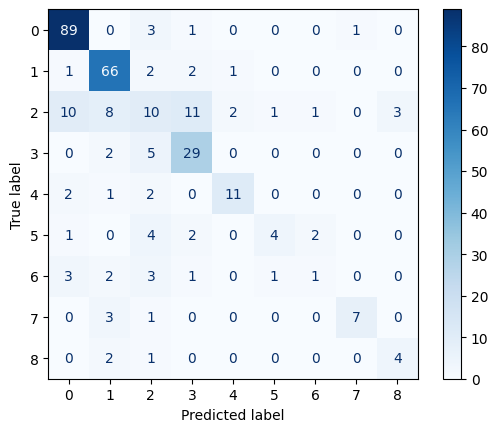

In [16]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_sg, X_test, y_test, values_format='d', cmap='Blues')


### RandomForestClassifier

In [17]:
# Treinar o modelo
# Criar o pipeline com normalização e Random Forest
pipelineRF = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, max_features=50000, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definir os hiperparâmetros para o Grid Search
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Realizar a busca de hiperparâmetros com validação cruzada
grid_search_rf = GridSearchCV(pipelineRF, param_grid_rf, cv=3, n_jobs=-1, scoring = 'f1_macro')
grid_search_rf.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_rf = grid_search_rf.best_estimator_
print("Melhores hiperparâmetros:", grid_search_rf.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_rf.predict(X_test)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


Melhores hiperparâmetros: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
F1-Score:  0.6129645311044842


In [18]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        94
           1       0.84      0.82      0.83        72
           2       0.35      0.13      0.19        46
           3       0.61      0.86      0.71        36
           4       0.65      0.81      0.72        16
           5       0.55      0.46      0.50        13
           6       0.60      0.27      0.38        11
           7       0.50      0.73      0.59        11
           8       0.83      0.71      0.77         7

    accuracy                           0.70       306
   macro avg       0.63      0.63      0.61       306
weighted avg       0.67      0.70      0.67       306



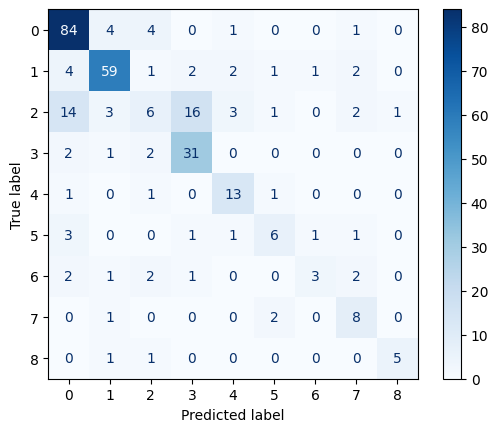

In [19]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_rf, X_test, y_test, values_format='d', cmap='Blues')


### XGBoost

In [20]:
# Treinar o modelo
# Criar o pipeline com normalização e Random Forest
pipelineXG = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, max_features=50000, ngram_range=(1,2))),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Definir os hiperparâmetros para o Grid Search
param_grid_xg = {
    'classifier__n_estimators': [300, 350, 400],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [4, 5]
}

# Grid Search com validação cruzada para XGBoost
grid_search_xgb = GridSearchCV(pipelineXG, param_grid_xg, cv=3, scoring='f1_macro', n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_xg = grid_search_xgb.best_estimator_
print("Melhores hiperparâmetros:", grid_search_xgb.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_xg.predict(X_test)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


Melhores hiperparâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 350}
F1-Score:  0.5756437995842348


In [21]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        94
           1       0.79      0.86      0.83        72
           2       0.35      0.26      0.30        46
           3       0.74      0.81      0.77        36
           4       0.75      0.75      0.75        16
           5       0.40      0.15      0.22        13
           6       0.40      0.18      0.25        11
           7       0.50      0.73      0.59        11
           8       0.46      0.86      0.60         7

    accuracy                           0.71       306
   macro avg       0.58      0.61      0.58       306
weighted avg       0.68      0.71      0.69       306



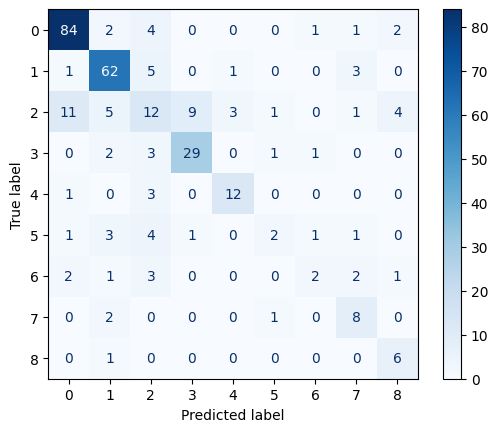

In [22]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_xg, X_test, y_test, values_format='d', cmap='Blues')

### Busca de hiperparâmetros com Optuna

In [25]:
# Usando Optuna para XGBoost
def objective(trial):

  classifier_name = trial.suggest_categorical("classifier", ["SGD", "XGBoost", "RandomForest"])
  if classifier_name == "SGD":
      sgd_loss =  trial.suggest_categorical("sgd_loss", ['log_loss', 'hinge', 'perceptron'])
      sgd_penalty =  trial.suggest_categorical("sgd_penalty", ['elasticnet', 'l1', 'l2'])

      classifier_obj = SGDClassifier(
          alpha=1e-06, random_state=42, loss=sgd_loss, penalty=sgd_penalty
      )

  elif classifier_name == "XGBoost":
      xg_n_estimators =  trial.suggest_int("xg_n_estimators", 100, 400, step=50)
      xg_max_depth = trial.suggest_int("xg_max_depth", 2, 10)

      classifier_obj = XGBClassifier(
          random_state=42, eval_metric='logloss', max_depth=xg_max_depth, n_estimators=xg_n_estimators,
          learning_rate=0.1
      )

  else:
      rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
      rf_max_features = trial.suggest_int("rf_max_features", 1, 3)
      rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 50)
      rf_criterion = trial.suggest_categorical("rf_criterion", ["gini", "entropy"])
      rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
      rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)

      classifier_obj = RandomForestClassifier(
          max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features,
          criterion=rf_criterion, random_state=42, min_samples_split=rf_min_samples_split,
          min_samples_leaf=rf_min_samples_leaf
      )

  score = cross_val_score(classifier_obj, X_train_tfidf, y_train, n_jobs=-1, cv=3, scoring='f1_macro')
  accuracy = score.mean()

  return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)
print('\n')
print(study.best_trial)


[I 2024-10-21 04:20:38,408] A new study created in memory with name: no-name-37d0c648-0a3e-4a33-917f-926743ef168a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-10-21 04:21:28,503] Trial 0 finished with value: 0.9180940539978915 and parameters: {'classifier': 'XGBoost', 'xg_n_estimators': 150, 'xg_max_depth': 2}. Best is trial 0 with value: 0.9180940539978915.
[I 2024-10-21 04:26:28,242] Trial 1 finished with value: 0.9490721236017787 and parameters: {'classifier': 'XGBoost', 'xg_n_estimators': 350, 'xg_max_depth': 7}. Best is trial 1 with value: 0.9490721236017787.
[I 2024-10-21 04:26:29,560] Trial 2 finished with value: 0.9477873398132762 and parameters: {'classifier': 'SGD', 'sgd_loss': 'perceptron', 'sgd_penalty': 'elasticnet'}. Best is trial 1 with value: 0.9490721236017787.
[I 2024-10-21 04:31:07,549] Trial 3 finished with value: 0.9493839816187489 and parameters: {'classifier': 'XGBoost', 'xg_n_estimators': 300, 'xg_max_depth': 7}. Best is trial 3 with value: 0.9493839816187489.
[I 2024-10-21 04:31:07,988] Trial 4 finished with value: 0.9575932714248846 and parameters: {'classifier': 'SGD', 'sgd_loss': 'log_loss', 'sgd_penalty':

In [26]:
# Get the best hyperparameters
best_params = study.best_trial.params

def exclude_key(dictionary, key_to_exclude):

  return {key.split('_')[1]: value for key, value in dictionary.items() if key != key_to_exclude}

new_best_params = exclude_key(best_params, 'classifier')

# Create a new model instance with the best hyperparameters
if study.best_trial.params['classifier'] == 'RandomForest':
    best_model = RandomForestClassifier(**new_best_params, random_state=42)
elif study.best_trial.params['classifier'] == 'XGBoost':
    best_model = XGBClassifier(**new_best_params, random_state=42, eval_metric='logloss', learning_rate=0.1)
else:  # Assuming SVG
    best_model = SGDClassifier(**new_best_params, alpha=1e-06, random_state=42)

# Train the model with the best hyperparameters
best_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test_tfidf)

score = best_model.score(X_test_tfidf, y_test)
print(f"Score: {score:.2f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

Score: 0.72
F1 Score: 0.59


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        94
           1       0.79      0.92      0.85        72
           2       0.32      0.22      0.26        46
           3       0.63      0.81      0.71        36
           4       0.79      0.69      0.73        16
           5       0.67      0.31      0.42        13
           6       0.25      0.09      0.13        11
           7       0.88      0.64      0.74        11
           8       0.57      0.57      0.57         7

    accuracy                           0.72       306
   macro avg       0.64      0.58      0.59       306
weighted avg       0.69      0.72      0.70       306



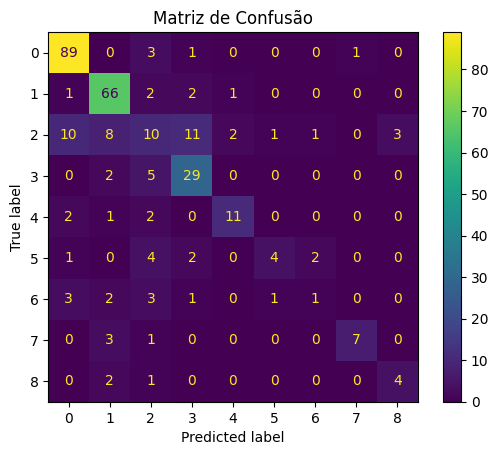

In [27]:
# Avaliar
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão')
plt.show()

In [28]:
# Salvar o Modelo
import joblib
joblib.dump(best_model, 'best_model.pkl')
print("Modelo salvo como 'best_model.pkl'")

Modelo salvo como 'best_model.pkl'
